<a href="https://colab.research.google.com/github/JasonAZ583/CSAiModel/blob/main/CPS4801AIModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jason Zaruma and Imad Gado
### CPS* 4801* 02
###Final Project



In [ ]:
# Skin Cancer Detection Using Deep Learning: Malignant vs. Benign Classification
# Authors: Jason Zaruma, Imad Gado
# Kean University

# Cell 1: Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import kagglehub

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 10
BASE_LR = 1e-4
FINE_LR = 1e-5
GAMMA = 2.0    # Focal loss gamma
ALPHA = 0.25   # Focal loss alpha

# Focal Loss Definition
def focal_loss(alpha=ALPHA, gamma=GAMMA):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        ce = tf.keras.backend.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        return alpha * tf.pow(1 - pt, gamma) * ce
    return loss_fn


In [ ]:
# Cell 2: Download Dataset, Load Paths & Compute Class Weights
path      = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")
train_dir = os.path.join(path, "train")
test_dir  = os.path.join(path, "test")

def load_images(folder, label):
    return [(os.path.join(folder, f), label)
            for f in os.listdir(folder)
            if f.lower().endswith((".jpg", ".png"))]

# Gather file paths
train_list = load_images(os.path.join(train_dir, "benign"),    0) + \
             load_images(os.path.join(train_dir, "malignant"), 1)
test_list  = load_images(os.path.join(test_dir,  "benign"),    0) + \
             load_images(os.path.join(test_dir,  "malignant"), 1)

np.random.shuffle(train_list)
np.random.shuffle(test_list)

# Split train → train/val
train_data, val_data = train_test_split(train_list, test_size=0.15, random_state=42)

# Helper: convert to DataFrame
def to_df(data):
    df = pd.DataFrame(data, columns=["filename","label"])
    df["label"] = df["label"].astype(str)
    return df

train_df = to_df(train_data)
val_df   = to_df(val_data)
test_df  = to_df(test_list)

# Compute class weights for balanced training
y_int = train_df["label"].astype(int)
cw = class_weight.compute_class_weight("balanced", classes=np.unique(y_int), y=y_int)
class_weights = dict(enumerate(cw))
print("Class weights:", class_weights)


Class weights: {0: np.float64(0.9109756097560976), 1: np.float64(1.1083086053412463)}


In [ ]:
# Cell 3: Data Augmentation & Generators
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.8,1.2)
)
val_aug  = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_gen = train_aug.flow_from_dataframe(
    train_df, x_col="filename", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="categorical"
)
val_gen = val_aug.flow_from_dataframe(
    val_df, x_col="filename", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode="categorical"
)
test_gen = test_aug.flow_from_dataframe(
    test_df, x_col="filename", y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode="categorical", shuffle=False
)


Found 2241 validated image filenames belonging to 2 classes.
Found 396 validated image filenames belonging to 2 classes.
Found 660 validated image filenames belonging to 2 classes.


In [ ]:
# Cell 4: EfficientNetB0 Model
base_model = EfficientNetB0(
    weights="imagenet", include_top=False,
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 4,171,774 (15.91 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Cell 5: Stage 1 – Train Classification Head
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=BASE_LR),
    loss=focal_loss(),
    metrics=["accuracy"]
)

callbacks1 = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-4, verbose=1)
]

history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=INITIAL_EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks1
)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_486']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


71/71 ━━━━━━━━━━━━━━━━━━━━ 71s 720ms/step - accuracy: 0.6620 - loss: 0.0526 - val_accuracy: 0.8207 - val_loss: 0.0248 - learning_rate: 1.0000e-04
Epoch 2/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 485ms/step - accuracy: 0.7396 - loss: 0.0387 - val_accuracy: 0.8157 - val_loss: 0.0238 - learning_rate: 1.0000e-04
Epoch 3/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 34s 480ms/step - accuracy: 0.7323 - loss: 0.0394 - val_accuracy: 0.8207 - val_loss: 0.0231 - learning_rate: 1.0000e-04
Epoch 4/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 33s 469ms/step - accuracy: 0.7634 - loss: 0.0358 - val_accuracy: 0.8258 - val_loss: 0.0228 - learning_rate: 1.0000e-04
Epoch 5/5
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 490ms/step - accuracy: 0.7742 - loss: 0.0324 - val_accuracy: 0.8283 - val_loss: 0.0226 - learning_rate: 1.0000e-04


In [ ]:
# Cell 6: Stage 2 – Fine-Tune Entire Backbone
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=FINE_LR),
    loss=focal_loss(),
    metrics=["accuracy"]
)

callbacks2 = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=5, min_lr=1e-4, verbose=1)
]

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=FINE_TUNE_EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks2
)


Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.7804 - loss: 0.0347 - val_accuracy: 0.6313 - val_loss: 0.0406 - learning_rate: 1.0000e-05
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 37s 515ms/step - accuracy: 0.7619 - loss: 0.0359 - val_accuracy: 0.7601 - val_loss: 0.0303 - learning_rate: 1.0000e-05
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 44s 614ms/step - accuracy: 0.7739 - loss: 0.0350 - val_accuracy: 0.8157 - val_loss: 0.0243 - learning_rate: 1.0000e-05
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 79s 568ms/step - accuracy: 0.7808 - loss: 0.0317 - val_accuracy: 0.7904 - val_loss: 0.0315 - learning_rate: 1.0000e-05
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 497ms/step - accuracy: 0.7860 - loss: 0.0302 - val_accuracy: 0.8131 - val_loss: 0.0304 - learning_rate: 1.0000e-05
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 35s 498ms/step - accuracy: 0.7905 - loss: 0.0312 - val_accuracy: 0.8157 - val_loss: 0.0268 - learning_rate: 1.0000e-05
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 36s 505ms/step - accur

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.8151 - loss: 0.0270

Final Test Accuracy: 81.67%



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_486']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 359ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.84      0.82      0.83       360
   Malignant       0.79      0.81      0.80       300

    accuracy                           0.82       660
   macro avg       0.82      0.82      0.82       660
weighted avg       0.82      0.82      0.82       660



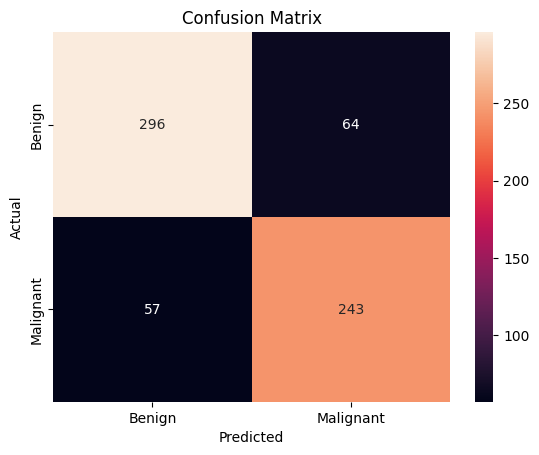

In [ ]:
# Cell 7: Final Evaluation & Visualization
loss, acc = model.evaluate(test_gen, verbose=1)
print(f"\nFinal Test Accuracy: {acc:.2%}\n")

y_pred = np.argmax(model.predict(test_gen), axis=1)
y_true = test_gen.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Benign","Malignant"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


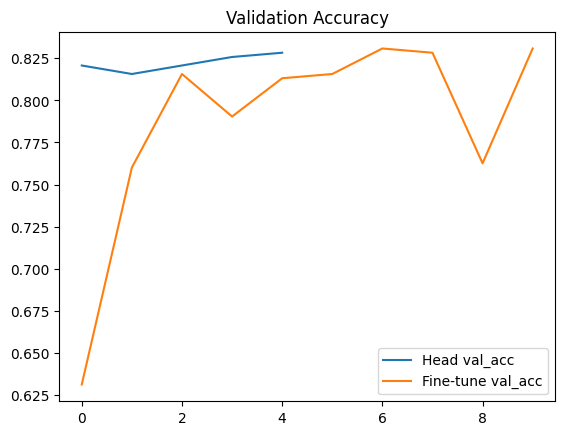

In [ ]:
plt.plot(history1.history['val_accuracy'], label='Head val_acc')
plt.plot(history2.history['val_accuracy'], label='Fine-tune val_acc')
plt.legend(); plt.title('Validation Accuracy'); plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_486']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


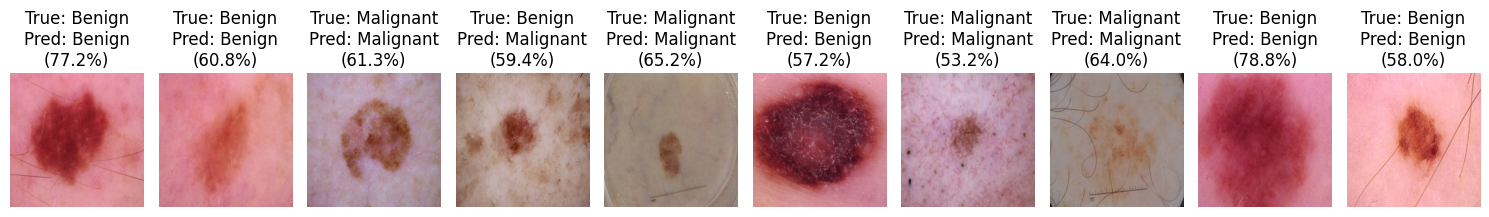

In [ ]:
# Cell 8b: Display Sample Predictions on Test Images

import random
from tensorflow.keras.preprocessing import image

# How many examples to show
NUM_SAMPLES = 10

# Randomly sample rows from test_df
sample_df = test_df.sample(NUM_SAMPLES, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 5))

for i, row in sample_df.iterrows():
    img_path   = row['filename']
    true_label = "Malignant" if int(row['label'])==1 else "Benign"

    # Load & preprocess
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = image.img_to_array(img) / 255.0
    batch = np.expand_dims(arr, 0)

    # Predict
    preds = model.predict(batch)[0]
    pred_idx   = np.argmax(preds)
    pred_label = "Malignant" if pred_idx==1 else "Benign"
    conf       = preds[pred_idx] * 100

    # Plot
    ax = plt.subplot(1, NUM_SAMPLES, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}\nPred: {pred_label}\n({conf:.1f}%)")
    plt.axis("off")

plt.tight_layout()
plt.show()
